# 부산광역시 쓰레기 배출량 예측 pt.1

### : 분석에 사용할 변수 전처리 (인구수, 종류별 주택, 주민등록세대수)

---

<br>

## 00. 기본 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

# 경고 메시지는 출력 X
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 한글 font 설정

import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin':           # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':        # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

<Axes: title={'center': '한글타이틀'}>

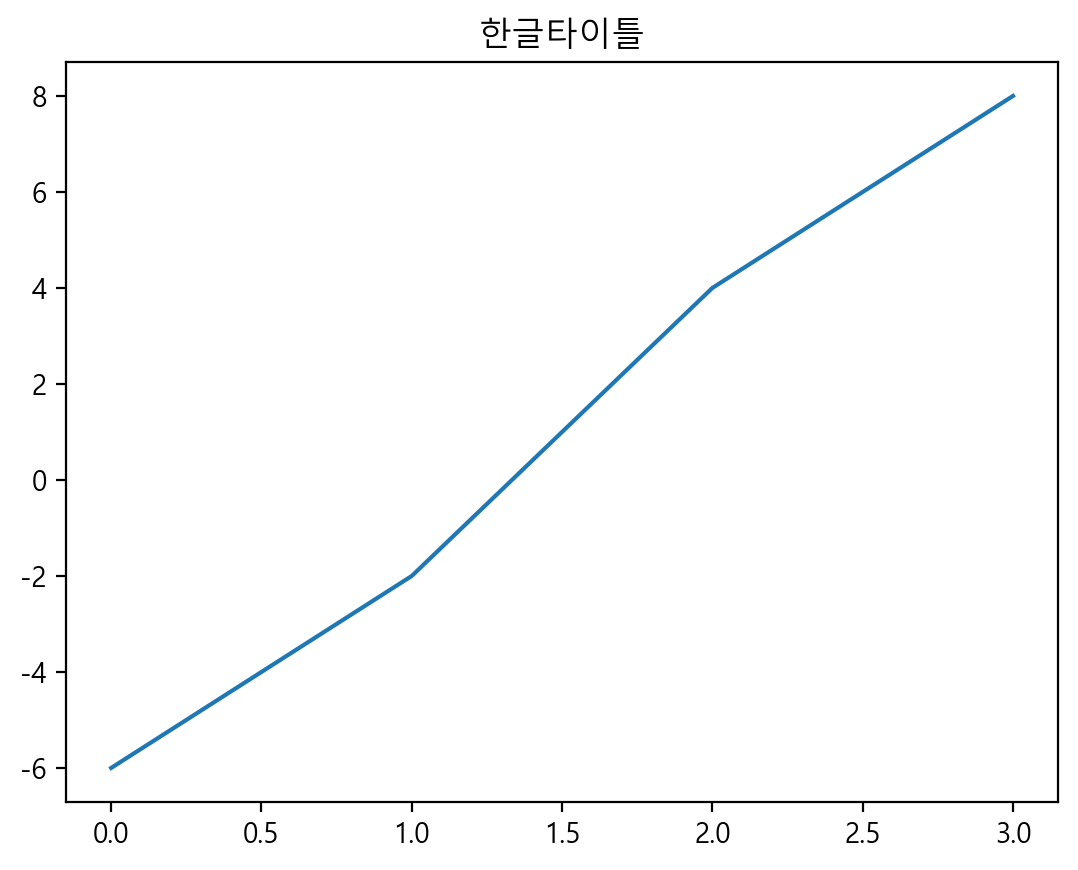

In [4]:
# 한글폰트와 마이너스 폰트 설정 확인

pd.Series([-6, -2, 4, 8]).plot(title="한글타이틀")

<br><br>

---
## 01. 폐기물 데이터
- 폐기물 데이터 기준으로 **행정구역을 맞추고 컬럼명을 통일**하기 위해 전처리된 폐기물 데이터 먼저 불러오기

In [71]:
# 전처리된 폐기물 데이터
waste = pd.read_csv("data/y_폐기물데이터_행정구역변경(세종, 군위 등)_민주.csv", encoding="cp949")

print(f"waste shape: {waste.shape}")
waste

waste shape: (42476, 12)


,행정구역,시도,시군구,폐기물_종류,폐기물_종류1,폐기물_종류2,재활용,소각,매립,기타,발생량,연도
0,서울_종로구,서울,종로구,종량제방식 등 혼합배출,가연성,폐지류,0.0,9125.0,4672.0,0.0,13797.0,2019
1,서울_종로구,서울,종로구,종량제방식 등 혼합배출,가연성,폐합성수지류,0.0,5365.5,2737.5,0.0,8103.0,2019
2,서울_종로구,서울,종로구,종량제방식 등 혼합배출,가연성,폐고무류,0.0,182.5,73.0,0.0,255.5,2019
3,서울_종로구,서울,종로구,종량제방식 등 혼합배출,가연성,폐섬유류,0.0,511.0,255.5,0.0,766.5,2019
4,서울_종로구,서울,종로구,종량제방식 등 혼합배출,가연성,음식물류 폐기물,0.0,693.5,365.0,0.0,1058.5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
42471,제주_서귀포시,제주,서귀포시,재활용 가능자원 분리배출,폐전기전자제품,NaN,1027.6,0.0,0.0,0.0,1027.6,2023
42472,제주_서귀포시,제주,서귀포시,재활용 가능자원 분리배출,폐가구류,NaN,0.0,0.0,0.0,0.0,0.0,2023
42473,제주_서귀포시,제주,서귀포시,재활용 가능자원 분리배출,기타,NaN,200.0,0.0,0.0,0.0,200.0,2023
42474,제주_서귀포시,제주,서귀포시,재활용 가능자원 분리배출,재활용 잔재물,NaN,0.0,1627.4,718.0,0.0,2345.4,2023


In [72]:
# 행정구역, 시도, 시군구, 연도 칼럼의 unique 개수 확인
print(f"행정구역 col의 unique: {len(waste['행정구역'].unique())}개\n")
print(f"시도 col의 unique: {len(waste['시도'].unique())}개\n{waste['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(waste['시군구'].unique())}개\n")
print(f"연도 col의 unique: {len(waste['연도'].unique())}개\n{waste['연도'].unique()}\n")

행정구역 col의 unique: 230개

시도 col의 unique: 17개
['서울' '부산' '대구' '인천' '광주' '대전' '울산' '세종' '경기' '강원' '충북' '충남' '전북' '전남'
 '경북' '경남' '제주']

시군구 col의 unique: 208개

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [73]:
# '19 - '23 사이에 행정구역이 변경된 곳이 있는지 확인
year_region = waste.groupby('연도')['행정구역'].unique().to_dict()
changed_regions = {}

years = sorted(year_region.keys())
for i in range(len(years) - 1):
    y1, y2 = years[i], years[i+1]
    s1, s2 = set(year_region[y1]), set(year_region[y2])

    added = s2 - s1
    removed = s1 - s2

    if added or removed:
        changed_regions[f'{y1} → {y2}'] = {
            '추가된 행정구역': list(added),
            '제거된 행정구역': list(removed)
        }
changed_regions

{'2021 → 2022': {'추가된 행정구역': [], '제거된 행정구역': ['인천_경제청']}}

In [74]:
waste[waste["행정구역"]=='인천_경제청']['연도'].unique()

array([2019, 2020, 2021], dtype=int64)

In [75]:
# 인천_경제청 데이터 삭제
waste_filtered = waste[waste['행정구역'] != '인천_경제청'].reset_index(drop=True)

# 행정구역, 시도, 시군구, 연도 칼럼의 unique 개수 **다시** 확인
print(f"행정구역 col의 unique: {len(waste_filtered['행정구역'].unique())}개\n")
print(f"시도 col의 unique: {len(waste_filtered['시도'].unique())}개\n{waste_filtered['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(waste_filtered['시군구'].unique())}개\n")
print(f"연도 col의 unique: {len(waste_filtered['연도'].unique())}개\n{waste_filtered['연도'].unique()}\n")

# 행정구역 230 >> 229
# 시군구 208 >> 207

행정구역 col의 unique: 229개

시도 col의 unique: 17개
['서울' '부산' '대구' '인천' '광주' '대전' '울산' '세종' '경기' '강원' '충북' '충남' '전북' '전남'
 '경북' '경남' '제주']

시군구 col의 unique: 207개

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [76]:
# new file로 저장
# waste_filtered.to_csv("폐기물데이터_행정구역변경_2.csv", encoding="cp949", index=False)

<br><br>

---
## 02. 주민등록세대수 데이터

In [186]:
## 주민등록세대수 데이터
household = pd.read_csv("data/prev/행정구역_시군구_별_주민등록세대수_20250612042813.csv", encoding="cp949")

print(f"household shape: {household.shape}")
household

household shape: (1617, 4)


,시점,시ㆍ도,행정구역(시군구)별,데이터
0,2019,서울,종로구,73947
1,2019,서울,중구,62739
2,2019,서울,용산구,110126
3,2019,서울,성동구,135838
4,2019,서울,광진구,164428
...,...,...,...,...
1612,2024,경남,함양군,20471
1613,2024,경남,거창군,31129
1614,2024,경남,합천군,23687
1615,2024,제주,제주시,225846


In [187]:
# 데이터 칼럼명 먼저 정리
household = household.rename(columns={
    '시점': '연도',
    '시ㆍ도': '시도',
    '행정구역(시군구)별': '시군구',
    '데이터': '주민등록세대수'
})
household.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연도       1617 non-null   int64 
 1   시도       1617 non-null   object
 2   시군구      1617 non-null   object
 3   주민등록세대수  1617 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 50.7+ KB


In [188]:
# "출장소" 또는 "경제청" 포함된 행 삭제
household_clean = household[~household['시군구'].str.contains('출장소|경제청')]
household_clean.shape

# 기존: (1617, 4)

(1569, 4)

In [189]:
# '24 데이터 삭제
household_clean = household_clean[household_clean['연도'] <= 2023].copy()

print(f"연도 col의 unique: {len(household_clean['연도'].unique())}개\n{household_clean['연도'].unique()}\n")

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [190]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_filtered['시군구'].unique()) - set(household_clean['시군구'].unique()))
print(set(household_clean['시군구'].unique()) - set(waste_filtered['시군구'].unique()))

set()
{'서북구', '흥덕구', '상당구', '영통구', '동안구', '권선구', '상록구', '마산합포구', '청원구', '중원구', '기흥구', '일산동구', '덕양구', '덕진구', '만안구', '단원구', '의창구', '처인구', '진해구', '성산구', '팔달구', '수지구', '마산회원구', '일산서구', '완산구', '서원구', '분당구', '수정구', '장안구', '동남구'}


#### 변경 list
- '오정구', '소사구', '원미구': '경기 부천시'
- '완산구', '덕진구': '전북 전주시'
- '상록구', '단원구': '경기 안산시'
- '일산동구', '덕양구', '일산서구': '경기 고양시'
- '성산구', '마산합포구', '진해구', '마산회원구', '의창구': '경남 창원시'
- '상당구', '청원구', '흥덕구', '서원구': '충북 청주시'
- '만안구', '동안구': '경기 안양시'
- '수지구', '처인구', '기흥구': '경기 용인시'
- '영통구', '권선구', '장안구', '팔달구': '경기 수원시'
- '분당구', '중원구', '수정구': '경기 성남시'
- '동남구', '서북구': '충남 천안시'

In [191]:
시군구_매핑 = {
    '오정구': '부천시',
    '소사구': '부천시',
    '원미구': '부천시',
    '완산구': '전주시',
    '덕진구': '전주시',
    '상록구': '안산시',
    '단원구': '안산시',
    '일산동구': '고양시',
    '덕양구': '고양시',
    '일산서구': '고양시',
    '성산구': '창원시',
    '마산합포구': '창원시',
    '진해구': '창원시',
    '마산회원구': '창원시',
    '의창구': '창원시',
    '상당구': '청주시',
    '청원구': '청주시',
    '흥덕구': '청주시',
    '서원구': '청주시',
    '만안구': '안양시',
    '동안구': '안양시',
    '수지구': '용인시',
    '처인구': '용인시',
    '기흥구': '용인시',
    '영통구': '수원시',
    '권선구': '수원시',
    '장안구': '수원시',
    '팔달구': '수원시',
    '분당구': '성남시',
    '중원구': '성남시',
    '수정구': '성남시',
    '동남구': '천안시',
    '서북구': '천안시'
}

# population의 시군구명 변경
household_clean['시군구'] = household_clean['시군구'].replace(시군구_매핑)

In [192]:
# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
household_clean = household_clean.groupby(['연도', '시도', '시군구'], as_index=False).sum(numeric_only=True)
household_clean.head()

,연도,시도,시군구,주민등록세대수
0,2019,강원,강릉시,99086
1,2019,강원,고성군,14445
2,2019,강원,동해시,41141
3,2019,강원,삼척시,34082
4,2019,강원,속초시,38689


In [193]:
# 시도, 시군구 칼럼의 unique 개수 확인
print(f"시도 col의 unique: {len(household_clean['시도'].unique())}개\n{household_clean['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(household_clean['시군구'].unique())}개\n")

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개



In [194]:
# 행정구역 col 추가
household_clean['행정구역'] = household_clean['시도'] + '_' + household_clean['시군구']
household_clean.head(3)

,연도,시도,시군구,주민등록세대수,행정구역
0,2019,강원,강릉시,99086,강원_강릉시
1,2019,강원,고성군,14445,강원_고성군
2,2019,강원,동해시,41141,강원_동해시


In [195]:
# 연도 + 행정구역 조합을 기준으로 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
household_keys = set(zip(household_clean['연도'], household_clean['행정구역']))

# household에는 있는데 waste에는 없는 조합
only_in_household = household_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - household_keys

print("✅ household에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_household))
print("✅ waste에만 있고 household에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ household에만 있는 조합 예시:", list(only_in_household))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ household에만 있고 waste에는 없는 연도-행정구역 조합 수: 14
✅ waste에만 있고 household에는 없는 연도-행정구역 조합 수: 4

❌ household에만 있는 조합 예시: [(2020, '경북_남구'), (2019, '경북_군위군'), (2021, '경북_남구'), (2022, '경북_남구'), (2023, '경북_남구'), (2020, '경북_북구'), (2021, '경북_북구'), (2019, '경북_남구'), (2022, '경북_북구'), (2023, '경북_북구'), (2019, '경북_북구'), (2020, '경북_군위군'), (2021, '경북_군위군'), (2022, '경북_군위군')]

❌ waste에만 있는 조합 예시: [(2021, '대구_군위군'), (2019, '대구_군위군'), (2022, '대구_군위군'), (2020, '대구_군위군')]


In [196]:
# 경북_남구, 경북_북구 제거
exclude = ['경북_남구', '경북_북구']
household_filtered = household_clean[~household_clean['행정구역'].isin(exclude)].copy()

In [197]:
# 경북 군위군 >> 대구 군위군으로 변경 (시도 & 행정구역)
mask_gunwi = (household_filtered['시도'] == '경북') & (household_filtered['시군구'] == '군위군')
household_filtered.loc[mask_gunwi, '시도'] = '대구'

# 행정구역 전체 다시 생성
household_filtered['행정구역'] = household_filtered['시도'] + '_' + household_filtered['시군구']
household_filtered[household_filtered['시군구'] == '군위군']['행정구역'].unique()

array(['대구_군위군'], dtype=object)

<br>

### waste df와 비교
- 행정구역 col unique: 229개
- 시도 col의 unique: 17개 ['서울' '부산' '대구' '인천' '광주' '대전' '울산' '세종' '경기' '강원' '충북' '충남' '전북' '전남' '경북' '경남' '제주']
- 시군구 col의 unique: 207개
- 연도 col의 unique: 5개 [2019 2020 2021 2022 2023]

In [198]:
# 연도 + 행정구역 조합을 기준으로 다시 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
household_keys = set(zip(household_filtered['연도'], household_filtered['행정구역']))

# household에는 있는데 waste에는 없는 조합
only_in_household = household_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - household_keys

print("✅ household에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_household))
print("✅ waste에만 있고 household에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ household에만 있는 조합 예시:", list(only_in_household))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ household에만 있고 waste에는 없는 연도-행정구역 조합 수: 0
✅ waste에만 있고 household에는 없는 연도-행정구역 조합 수: 0

❌ household에만 있는 조합 예시: []

❌ waste에만 있는 조합 예시: []


In [199]:
# 행정구역, 시도, 시군구, 연도 칼럼의 unique 개수 **다시** 확인
print(f"행정구역 col의 unique: {len(household_filtered['행정구역'].unique())}개\n")
print(f"시도 col의 unique: {len(household_filtered['시도'].unique())}개\n{household_filtered['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(household_filtered['시군구'].unique())}개\n")
print(f"연도 col의 unique: {len(household_filtered['연도'].unique())}개\n{household_filtered['연도'].unique()}\n")

행정구역 col의 unique: 229개

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '대구' '광주' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [200]:
household_filtered.isnull().sum()

연도         0
시도         0
시군구        0
주민등록세대수    0
행정구역       0
dtype: int64

In [201]:
household_filtered[household_filtered['주민등록세대수'] == 0]

,연도,시도,시군구,주민등록세대수,행정구역


In [204]:
# household_filtered.to_csv("data/x_주민등록세대수_행정구역변경.csv", encoding="cp949", index=False)

<br><br>

---
## 03. 인구 수 데이터

In [205]:
## 주민등록세대수 데이터
population = pd.read_csv("data/prev/행정구역_시군구_별_인구수_20250612171906.csv", encoding="cp949")

print(f"population shape: {population.shape}")
population.head()

population shape: (1569, 4)


,시ㆍ도,시군구,연도,총인구수 (명)
0,서울,종로구,2019,151290
1,서울,종로구,2020,149384
2,서울,종로구,2021,144683
3,서울,종로구,2022,141379
4,서울,종로구,2023,139417


In [206]:
# 데이터 칼럼명 먼저 정리
population = population.rename(columns={'시ㆍ도': '시도'})
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   시도        1569 non-null   object
 1   시군구       1569 non-null   object
 2   연도        1569 non-null   int64 
 3   총인구수 (명)  1569 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 49.2+ KB


In [207]:
# "출장소" 또는 "경제청" 포함된 행 삭제
population_clean = population[~population['시군구'].str.contains('출장소|경제청')]
population_clean.shape

(1569, 4)

In [208]:
# '24 데이터 삭제
population_clean = population_clean[population_clean['연도'] <= 2023].copy()

print(f"연도 col의 unique: {len(population_clean['연도'].unique())}개\n{population_clean['연도'].unique()}\n")

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [209]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_filtered['시군구'].unique()) - set(population_clean['시군구'].unique()))
print(set(population_clean['시군구'].unique()) - set(waste_filtered['시군구'].unique()))

set()
{'서북구', '흥덕구', '상당구', '영통구', '동안구', '권선구', '상록구', '마산합포구', '청원구', '중원구', '기흥구', '일산동구', '덕양구', '덕진구', '만안구', '단원구', '의창구', '처인구', '진해구', '성산구', '팔달구', '수지구', '마산회원구', '일산서구', '완산구', '서원구', '분당구', '수정구', '장안구', '동남구'}


In [210]:
# population의 시군구명 변경
population_clean['시군구'] = population_clean['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
population_clean = population_clean.groupby(['연도', '시도', '시군구'], as_index=False).sum(numeric_only=True)
population_clean.head()

,연도,시도,시군구,총인구수 (명)
0,2019,강원,강릉시,213442
1,2019,강원,고성군,27260
2,2019,강원,동해시,90522
3,2019,강원,삼척시,67228
4,2019,강원,속초시,81786


In [211]:
# 시도, 시군구 칼럼의 unique 개수 확인
print(f"시도 col의 unique: {len(population_clean['시도'].unique())}개\n{population_clean['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(population_clean['시군구'].unique())}개\n")

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개



In [212]:
# 행정구역 col 추가
population_clean['행정구역'] = population_clean['시도'] + '_' + population_clean['시군구']
population_clean.head(3)

,연도,시도,시군구,총인구수 (명),행정구역
0,2019,강원,강릉시,213442,강원_강릉시
1,2019,강원,고성군,27260,강원_고성군
2,2019,강원,동해시,90522,강원_동해시


In [213]:
# 연도 + 행정구역 조합을 기준으로 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
population_keys = set(zip(population_clean['연도'], population_clean['행정구역']))

# population에는 있는데 waste에는 없는 조합
only_in_population = population_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - population_keys

print("✅ population에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_population))
print("✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ population에만 있는 조합 예시:", list(only_in_population))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ population에만 있고 waste에는 없는 연도-행정구역 조합 수: 14
✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수: 4

❌ population에만 있는 조합 예시: [(2020, '경북_남구'), (2019, '경북_군위군'), (2021, '경북_남구'), (2022, '경북_남구'), (2023, '경북_남구'), (2020, '경북_북구'), (2021, '경북_북구'), (2019, '경북_남구'), (2022, '경북_북구'), (2023, '경북_북구'), (2019, '경북_북구'), (2020, '경북_군위군'), (2021, '경북_군위군'), (2022, '경북_군위군')]

❌ waste에만 있는 조합 예시: [(2021, '대구_군위군'), (2019, '대구_군위군'), (2022, '대구_군위군'), (2020, '대구_군위군')]


In [214]:
# 경북_남구, 경북_북구 제거
population_filtered = population_clean[~population_clean['행정구역'].isin(exclude)].copy()

# 경북 군위군 >> 대구 군위군으로 변경 (시도 & 행정구역)
mask_gunwi = (population_filtered['시도'] == '경북') & (population_filtered['시군구'] == '군위군')
population_filtered.loc[mask_gunwi, '시도'] = '대구'

# 행정구역 전체 다시 생성
population_filtered['행정구역'] = population_filtered['시도'] + '_' + population_filtered['시군구']
population_filtered[population_filtered['시군구'] == '군위군']['행정구역'].unique()

array(['대구_군위군'], dtype=object)

### 전처리 후 결과 다시 확인

In [215]:
# 연도 + 행정구역 조합을 기준으로 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
population_keys = set(zip(population_filtered['연도'], population_filtered['행정구역']))

# population에는 있는데 waste에는 없는 조합
only_in_population = population_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - population_keys

print("✅ population에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_population))
print("✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ population에만 있는 조합 예시:", list(only_in_population))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ population에만 있고 waste에는 없는 연도-행정구역 조합 수: 0
✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수: 0

❌ population에만 있는 조합 예시: []

❌ waste에만 있는 조합 예시: []


In [216]:
# 행정구역, 시도, 시군구, 연도 칼럼의 unique 개수 **다시** 확인
print(f"행정구역 col의 unique: {len(population_filtered['행정구역'].unique())}개\n")
print(f"시도 col의 unique: {len(population_filtered['시도'].unique())}개\n{population_filtered['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(population_filtered['시군구'].unique())}개\n")
print(f"연도 col의 unique: {len(population_filtered['연도'].unique())}개\n{population_filtered['연도'].unique()}\n")

행정구역 col의 unique: 229개

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '대구' '광주' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [217]:
population_filtered.isnull().sum()

연도          0
시도          0
시군구         0
총인구수 (명)    0
행정구역        0
dtype: int64

In [218]:
population_filtered[population_filtered['총인구수 (명)'] == 0]

,연도,시도,시군구,총인구수 (명),행정구역


In [220]:
# population_filtered.to_csv("data/x_인구수_행정구역변경.csv", encoding="cp949", index=False)

<br><br>

---
## 04. 주택 유형의 수 및 비율 데이터

In [221]:
housing = pd.read_csv("data/prev/행정구역_시군구_별_종류별_주택_20250613023403.csv", encoding="cp949")

print(f"housing shape: {housing.shape}")
housing.head()

housing shape: (1305, 9)


,시ㆍ도,시군구,연도,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택
0,서울,종로구,2019,46440,12421,15290,5459,12349,921
1,서울,종로구,2020,46859,12259,15688,5460,12540,912
2,서울,종로구,2021,46885,11987,15775,5490,12725,908
3,서울,종로구,2022,46810,11823,15923,5532,12651,881
4,서울,종로구,2023,47025,11620,16300,5544,12695,866


In [222]:
# 데이터 칼럼명 먼저 정리
housing = housing.rename(columns={'시ㆍ도': '시도'})
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   시도            1305 non-null   object
 1   시군구           1305 non-null   object
 2   연도            1305 non-null   int64 
 3   주택            1305 non-null   int64 
 4   단독주택-계        1305 non-null   int64 
 5   아파트           1305 non-null   int64 
 6   연립주택          1305 non-null   int64 
 7   다세대주택         1305 non-null   int64 
 8   비주거용 건물 내 주택  1305 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 91.9+ KB


In [223]:
# "출장소" 또는 "경제청" 포함된 행 삭제
housing_clean = housing[~housing['시군구'].str.contains('출장소|경제청')]
housing_clean.shape

(1305, 9)

In [224]:
# waste_clean과 merge하기 전에 unique로 시군구명 확인
print(set(waste_filtered['시군구'].unique()) - set(housing_clean['시군구'].unique()))
print(set(housing_clean['시군구'].unique()) - set(waste_filtered['시군구'].unique()))

set()
{'서북구', '흥덕구', '상당구', '영통구', '동안구', '권선구', '상록구', '마산합포구', '청원구', '중원구', '기흥구', '일산동구', '덕양구', '덕진구', '만안구', '단원구', '의창구', '처인구', '진해구', '성산구', '팔달구', '수지구', '마산회원구', '일산서구', '완산구', '서원구', '분당구', '수정구', '장안구', '동남구'}


In [225]:
# housing의 시군구명 변경
housing_clean['시군구'] = housing_clean['시군구'].replace(시군구_매핑)

# 중복된 (연도, 시ㆍ도, 시군구) 에 대해 sum 처리
housing_clean = housing_clean.groupby(['연도', '시도', '시군구'], as_index=False).sum(numeric_only=True)
housing_clean.head()

,연도,시도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735
1,2019,강원,고성군,11559,8764,2193,109,121,372
2,2019,강원,동해시,38906,10461,24961,1657,1152,675
3,2019,강원,삼척시,30699,13381,14268,1565,920,565
4,2019,강원,속초시,36090,8544,24949,1497,483,617


In [226]:
# 시도, 시군구 칼럼의 unique 개수 확인
print(f"시도 col의 unique: {len(housing_clean['시도'].unique())}개\n{housing_clean['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(housing_clean['시군구'].unique())}개\n")

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개



In [227]:
# 행정구역 col 추가
housing_clean['행정구역'] = housing_clean['시도'] + '_' + housing_clean['시군구']
housing_clean.head(3)

,연도,시도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,행정구역
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735,강원_강릉시
1,2019,강원,고성군,11559,8764,2193,109,121,372,강원_고성군
2,2019,강원,동해시,38906,10461,24961,1657,1152,675,강원_동해시


In [228]:
# 연도 + 행정구역 조합을 기준으로 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
housing_keys = set(zip(housing_clean['연도'], housing_clean['행정구역']))

# population에는 있는데 waste에는 없는 조합
only_in_housing = housing_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - housing_keys

print("✅ housing에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_housing))
print("✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ housing에만 있는 조합 예시:", list(only_in_housing))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ housing에만 있고 waste에는 없는 연도-행정구역 조합 수: 14
✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수: 4

❌ housing에만 있는 조합 예시: [(2020, '경북_남구'), (2019, '경북_군위군'), (2021, '경북_남구'), (2022, '경북_남구'), (2023, '경북_남구'), (2020, '경북_북구'), (2021, '경북_북구'), (2019, '경북_남구'), (2022, '경북_북구'), (2023, '경북_북구'), (2019, '경북_북구'), (2020, '경북_군위군'), (2021, '경북_군위군'), (2022, '경북_군위군')]

❌ waste에만 있는 조합 예시: [(2021, '대구_군위군'), (2019, '대구_군위군'), (2022, '대구_군위군'), (2020, '대구_군위군')]


In [229]:
# 경북_남구, 경북_북구 제거
housing_filtered = housing_clean[~housing_clean['행정구역'].isin(exclude)].copy()

# 경북 군위군 >> 대구 군위군으로 변경 (시도 & 행정구역)
mask_gunwi = (housing_filtered['시도'] == '경북') & (housing_filtered['시군구'] == '군위군')
housing_filtered.loc[mask_gunwi, '시도'] = '대구'

# 행정구역 전체 다시 생성
housing_filtered['행정구역'] = housing_filtered['시도'] + '_' + housing_filtered['시군구']
housing_filtered[housing_filtered['시군구'] == '군위군']['행정구역'].unique()

array(['대구_군위군'], dtype=object)

### 전처리 후 결과 다시 확인

In [230]:
# 연도 + 행정구역 조합을 기준으로 비교
waste_keys = set(zip(waste_filtered['연도'], waste_filtered['행정구역']))
housing_keys = set(zip(housing_filtered['연도'], housing_filtered['행정구역']))

# population에는 있는데 waste에는 없는 조합
only_in_housing = housing_keys - waste_keys

# waste에는 있는데 household에는 없는 조합
only_in_waste = waste_keys - housing_keys

print("✅ housing에만 있고 waste에는 없는 연도-행정구역 조합 수:", len(only_in_housing))
print("✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수:", len(only_in_waste))

# 필요 시 상세 확인
print("\n❌ housing에만 있는 조합 예시:", list(only_in_housing))
print("\n❌ waste에만 있는 조합 예시:", list(only_in_waste))

✅ housing에만 있고 waste에는 없는 연도-행정구역 조합 수: 0
✅ waste에만 있고 population에는 없는 연도-행정구역 조합 수: 0

❌ housing에만 있는 조합 예시: []

❌ waste에만 있는 조합 예시: []


In [231]:
# 행정구역, 시도, 시군구, 연도 칼럼의 unique 개수 **다시** 확인
print(f"행정구역 col의 unique: {len(housing_filtered['행정구역'].unique())}개\n")
print(f"시도 col의 unique: {len(housing_filtered['시도'].unique())}개\n{housing_filtered['시도'].unique()}\n")
print(f"시군구 col의 unique: {len(housing_filtered['시군구'].unique())}개\n")
print(f"연도 col의 unique: {len(housing_filtered['연도'].unique())}개\n{housing_filtered['연도'].unique()}\n")

행정구역 col의 unique: 229개

시도 col의 unique: 17개
['강원' '경기' '경남' '경북' '대구' '광주' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']

시군구 col의 unique: 207개

연도 col의 unique: 5개
[2019 2020 2021 2022 2023]



In [232]:
housing_filtered.isnull().sum()

연도              0
시도              0
시군구             0
주택              0
단독주택-계          0
아파트             0
연립주택            0
다세대주택           0
비주거용 건물 내 주택    0
행정구역            0
dtype: int64

In [233]:
(housing_filtered.iloc[:, 2:] == 0.0).any()

시군구             False
주택              False
단독주택-계          False
아파트             False
연립주택            False
다세대주택           False
비주거용 건물 내 주택    False
행정구역            False
dtype: bool

<br>

### 비율 계산

In [234]:
# '주택' 행이 나머지 값의 합인지 모든 행에 대해 먼저 확인
component_cols = ['단독주택-계', '아파트', '연립주택', '다세대주택', '비주거용 건물 내 주택']

# 각 행의 합 계산
housing_sum = housing_filtered[component_cols].sum(axis=1)

# '주택' col의 값이랑 같은지 확인
matches = housing_filtered['주택'] == housing_sum
print(f"주택의 각 유형의 합이 '주택'과 일치하면 True 아니면 False: {matches.all()}")

주택의 각 유형의 합이 '주택'과 일치하면 True 아니면 False: True


In [235]:
housing_filtered['단독주택비율'] = round(housing_filtered['단독주택-계'] / housing_filtered['주택'], 4)
housing_filtered['아파트비율'] = round(housing_filtered['아파트'] / housing_filtered['주택'], 4)
housing_filtered['연립주택비율'] = round(housing_filtered['연립주택'] / housing_filtered['주택'], 4)
housing_filtered['다세대주택비율'] = round(housing_filtered['다세대주택'] / housing_filtered['주택'], 4)
housing_filtered['비주거용주택비율'] = round(housing_filtered['비주거용 건물 내 주택'] / housing_filtered['주택'], 4)

housing_filtered.head(1)

,연도,시도,시군구,주택,단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,행정구역,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율
0,2019,강원,강릉시,85780,29481,50175,2919,1470,1735,강원_강릉시,0.3437,0.5849,0.034,0.0171,0.0202


In [247]:
# 주택 열만 삭제
housing_dropped = housing_filtered.drop("주택", axis=1)

print(f"drop 전: {housing_filtered.shape}")
print(f"drop 후: {housing_dropped.shape}")

drop 전: (1145, 15)
drop 후: (1145, 14)


In [244]:
# housing_dropped.to_csv("data/x_주택유형수및비율_행정구역변경.csv", encoding="cp949", index=False)

<br><br>

---
## 05. data mergeeeeee
- 주민등록세대수 - 인구수 - 주택유형수및비율 데이터프레임 병합

In [245]:
print(f"household_filtered shape: {household_filtered.shape}")           # 세대수
print(f"population_filtered shape: {population_filtered.shape}")         # 인구수
print(f"housing_dropped shape: {housing_dropped.shape}")                 # 주택 유형별 비율

household_filtered shape: (1145, 5)
population_filtered shape: (1145, 5)
housing_dropped shape: (1145, 14)


In [248]:
print(f"household_filtered: {household_filtered.columns}")           # 세대수
print(f"population_filtered: {population_filtered.columns}")         # 인구수
print(f"housing_dropped: {housing_dropped.columns}")                 # 주택 유형별 비율

household_filtered: Index(['연도', '시도', '시군구', '주민등록세대수', '행정구역'], dtype='object')
population_filtered: Index(['연도', '시도', '시군구', '총인구수 (명)', '행정구역'], dtype='object')
housing_dropped: Index(['연도', '시도', '시군구', '단독주택-계', '아파트', '연립주택', '다세대주택', '비주거용 건물 내 주택',
       '행정구역', '단독주택비율', '아파트비율', '연립주택비율', '다세대주택비율', '비주거용주택비율'],
      dtype='object')


In [249]:
# merge 시작 (outer join 사용)
merged_df = household_filtered.copy()

# population_clean merge
merged_df = pd.merge(merged_df, population_filtered[['연도', '행정구역', '총인구수 (명)']], on=['연도', '행정구역'], how='outer')

# housing_filtered merge
merged_df = pd.merge(merged_df, housing_filtered[['연도', '행정구역', '단독주택-계', '아파트', '연립주택', '다세대주택',
                                                  '비주거용 건물 내 주택', '단독주택비율', '아파트비율', '연립주택비율',
                                                  '다세대주택비율', '비주거용주택비율']], on=['연도', '행정구역'], how='outer')

print(f"병합된 데이터프레임 shape: {merged_df.shape}")
merged_df.head()

병합된 데이터프레임 shape: (1145, 16)


,연도,시도,시군구,주민등록세대수,행정구역,총인구수 (명),단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율
0,2019,강원,강릉시,99086,강원_강릉시,213442,29481,50175,2919,1470,1735,0.3437,0.5849,0.0340,0.0171,0.0202
1,2019,강원,고성군,14445,강원_고성군,27260,8764,2193,109,121,372,0.7582,0.1897,0.0094,0.0105,0.0322
2,2019,강원,동해시,41141,강원_동해시,90522,10461,24961,1657,1152,675,0.2689,0.6416,0.0426,0.0296,0.0173
3,2019,강원,삼척시,34082,강원_삼척시,67228,13381,14268,1565,920,565,0.4359,0.4648,0.0510,0.0300,0.0184
4,2019,강원,속초시,38689,강원_속초시,81786,8544,24949,1497,483,617,0.2367,0.6913,0.0415,0.0134,0.0171


In [250]:
# 행정구역 col을 연도 다음으로 옮기기
cols = list(merged_df.columns)

cols.remove('행정구역')
insert_idx = cols.index('연도') + 1
cols.insert(insert_idx, '행정구역')

# 순서 재정렬
merged_df = merged_df[cols]
merged_df

,연도,행정구역,시도,시군구,주민등록세대수,총인구수 (명),단독주택-계,아파트,연립주택,다세대주택,비주거용 건물 내 주택,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율
0,2019,강원_강릉시,강원,강릉시,99086,213442,29481,50175,2919,1470,1735,0.3437,0.5849,0.0340,0.0171,0.0202
1,2019,강원_고성군,강원,고성군,14445,27260,8764,2193,109,121,372,0.7582,0.1897,0.0094,0.0105,0.0322
2,2019,강원_동해시,강원,동해시,41141,90522,10461,24961,1657,1152,675,0.2689,0.6416,0.0426,0.0296,0.0173
3,2019,강원_삼척시,강원,삼척시,34082,67228,13381,14268,1565,920,565,0.4359,0.4648,0.0510,0.0300,0.0184
4,2019,강원_속초시,강원,속초시,38689,81786,8544,24949,1497,483,617,0.2367,0.6913,0.0415,0.0134,0.0171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,2023,충북_제천시,충북,제천시,66038,130194,21467,32675,1898,1011,1374,0.3674,0.5593,0.0325,0.0173,0.0235
1141,2023,충북_증평군,충북,증평군,18944,37484,4109,11941,472,276,275,0.2407,0.6994,0.0276,0.0162,0.0161
1142,2023,충북_진천군,충북,진천군,42751,86254,11070,24248,1652,3197,458,0.2725,0.5969,0.0407,0.0787,0.0113
1143,2023,충북_청주시,충북,청주시,798184,1704378,125514,494104,9418,12346,8070,0.1933,0.7608,0.0145,0.0190,0.0124


In [252]:
# merged_df 저장
# merged_df.to_csv("data/x_주민등록세대수_인구수_주택유형_병합.csv", encoding="cp949", index=False)